In [59]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from calendar import c
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [60]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [61]:
# 获取当前文件所在目录的父目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)

from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions, plot_xgb_feature_importance


In [62]:
sheet = pd.read_excel('data_input/玻璃期货价格拟合残差-玻璃企业库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['玻璃期货价格拟合残差/玻璃企业库存'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,玻璃期货价格拟合残差/玻璃企业库存,中国10年期国债收益率Non-Trend/F0.2,玻璃现货基差（指数）,30大中城市商品房成交面积/7DMATrend/F0.05,玻璃社会库存/沙河超季节性/3年,70大中城市新房房价环比,每日建材成交/66DMA同比,玻璃区域价差（华中-西南）,玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年,新增人民币贷款/居民/中长期/3MMA,玻璃区域价差（华东-华中）,玻璃深加工企业订单天数同差,玻璃周度表需（新）(预测，需求-7.5%),新增人民币贷款/居民/12MMA,玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA
2025-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.4921,NaN,NaN,NaN,106.7799,NaN,9.8897


In [63]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/中国10年期国债收益率Non-Trend_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/中国10年期国债收益率Non-Trend_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/中国10年期国债收益率Non-Trend_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['实际值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,预测值_全量
19,2025-11-03,0.12407
18,2025-11-04,0.12407
17,2025-11-05,0.12407
16,2025-11-06,0.12407
15,2025-11-07,0.12407


In [64]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值_全量']],
    on='Date',
    how='left'
)
sheet_daily['中国10年期国债收益率Non-Trend/F0.2'] = sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].fillna(sheet_daily['预测值_全量'])
sheet_daily = sheet_daily.drop(columns=['预测值_全量'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [65]:
sheet.columns

Index(['玻璃期货价格拟合残差/玻璃企业库存', '中国10年期国债收益率Non-Trend/F0.2', '玻璃现货基差（指数）',
       '30大中城市商品房成交面积/7DMATrend/F0.05', '玻璃社会库存/沙河超季节性/3年', '70大中城市新房房价环比',
       '每日建材成交/66DMA同比', '玻璃区域价差（华中-西南）', '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年',
       '新增人民币贷款/居民/中长期/3MMA', '玻璃区域价差（华东-华中）', '玻璃深加工企业订单天数同差',
       '玻璃周度表需（新）(预测，需求-7.5%)', '新增人民币贷款/居民/12MMA',
       '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA'],
      dtype='object')

In [66]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL

def get_stl_residual(sheet, col_name):
    # 将数据转换为时间序列
    ts = sheet[col_name].dropna()
    # 确保索引是日期类型
    if not isinstance(ts.index, pd.DatetimeIndex):
        ts.index = pd.to_datetime(ts.index)
    # 使用STL分解,period=365表示按年度周期分解
    try:
        stl = STL(ts, period=365)
        result = stl.fit()
        # 获取残差部分
        residual = result.resid 
        # 创建新的Series,保持原始索引
        residual_series = pd.Series(residual, index=ts.index)
        # 将结果合并回原始DataFrame
        sheet[f'{col_name}_residual'] = residual_series       
    except Exception as e:
        print(f"STL分解出错: {str(e)}")
        sheet[f'{col_name}_residual'] = np.nan
    return sheet

In [67]:
################################# 处理缺失值 #################################
fill_methods = {
'中国10年期国债收益率Non-Trend/F0.2':'interpolate', 
'玻璃现货基差（指数）':'interpolate',
'30大中城市商品房成交面积/7DMATrend/F0.05':'interpolate', 
'玻璃社会库存/沙河超季节性/3年':'interpolate', 
'70大中城市新房房价环比':'interpolate',
'每日建材成交/66DMA同比':'interpolate', 
'玻璃区域价差（华中-西南）':'interpolate', 
'玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年':'interpolate',
'新增人民币贷款/居民/中长期/3MMA':'interpolate',
'玻璃区域价差（华东-华中）':'interpolate', 
'玻璃深加工企业订单天数同差':'interpolate',
'玻璃周度表需（新）(预测，需求-7.5%)':'interpolate',
'新增人民币贷款/居民/12MMA': 'interpolate',
'玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA':'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '玻璃期货价格拟合残差/玻璃企业库存'] = sheet.loc[:last_day, '玻璃期货价格拟合残差/玻璃企业库存'].interpolate(method='linear')

#################################  因子处理  #################################
sheet = get_stl_residual(sheet, '玻璃周度表需（新）(预测，需求-7.5%)')

sheet['玻璃现货基差（指数）_提前60天'] = sheet['玻璃现货基差（指数）'].shift(60)
sheet['30大中城市商品房成交面积/7DMATrend/F0.05_提前100天'] = sheet['30大中城市商品房成交面积/7DMATrend/F0.05'].shift(200)
sheet['玻璃社会库存/沙河超季节性/3年_提前20天'] = sheet['玻璃社会库存/沙河超季节性/3年'].shift(20)
sheet['70大中城市新房房价环比_提前30天'] = sheet['70大中城市新房房价环比'].shift(30)
sheet['每日建材成交/66DMA同比_提前90天'] = sheet['每日建材成交/66DMA同比'].shift(90)
sheet['玻璃区域价差（华中-西南）_提前15天'] = sheet['玻璃区域价差（华中-西南）'].shift(15)
sheet['新增人民币贷款/居民/中长期/3MMA_提前80天'] = sheet['新增人民币贷款/居民/中长期/3MMA'].shift(80)
sheet['玻璃区域价差（华东-华中）_提前5天'] = sheet['玻璃区域价差（华东-华中）'].shift(5)
sheet['玻璃深加工企业订单天数同差_提前140天'] = sheet['玻璃深加工企业订单天数同差'].shift(140)
sheet['新增人民币贷款/居民/12MMA_提前60天'] = sheet['新增人民币贷款/居民/12MMA'].shift(60)


sheet['玻璃社会库存/沙河超季节性/3年_提前20天_逆序'] = reverse_column(sheet, '玻璃社会库存/沙河超季节性/3年_提前20天')
sheet['玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年_逆序'] = reverse_column(sheet, '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年')
sheet['玻璃区域价差（华中-西南）_提前15天_逆序'] = reverse_column(sheet, '玻璃区域价差（华中-西南）_提前15天')
sheet['玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA_逆序'] = reverse_column(sheet, '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA')

sheet['中国10年期国债收益率Non-Trend/F0.2_2023-01-03之后'] = np.where(sheet.index >= pd.Timestamp('2023-01-03'),sheet['中国10年期国债收益率Non-Trend/F0.2'],np.nan)
sheet['玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年_逆序_2023-01-06之后'] = np.where(sheet.index >= pd.Timestamp('2023-01-06'),sheet['玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年_逆序'],np.nan)
sheet['玻璃周度表需（新）(预测，需求-7.5%)_residual_2024-01-05之后'] = np.where(sheet.index >= pd.Timestamp('2024-01-05'),sheet['玻璃周度表需（新）(预测，需求-7.5%)_residual'],np.nan)
sheet['玻璃社会库存/沙河超季节性/3年_提前20天_逆序_2024-04-02之后'] = np.where(sheet.index >= pd.Timestamp('2024-01-01'),sheet['玻璃社会库存/沙河超季节性/3年_提前20天_逆序'],np.nan)
sheet['30大中城市商品房成交面积/7DMATrend/F0.05_提前100天_2021-06-01之后'] = np.where(sheet.index >= pd.Timestamp('2021-06-01'),sheet['30大中城市商品房成交面积/7DMATrend/F0.05_提前100天'],np.nan)

sheet['玻璃区域价差（华东-华中）_提前5天_2023-01-03之后'] = np.where(sheet.index >= pd.Timestamp('2023-01-03'),sheet['玻璃区域价差（华东-华中）_提前5天'],np.nan)
sheet['玻璃深加工企业订单天数同差_提前140天_2023-05-30之后'] = np.where(sheet.index >= pd.Timestamp('2023-05-30'),sheet['玻璃深加工企业订单天数同差_提前140天'],np.nan)
sheet['每日建材成交/66DMA同比_提前90天_2023-05-29之后'] = np.where(sheet.index >= pd.Timestamp('2023-05-29'),sheet['每日建材成交/66DMA同比_提前90天'],np.nan)
sheet['玻璃区域价差（华中-西南）_提前15天_逆序_2023-05-04之后'] = np.where(sheet.index >= pd.Timestamp('2023-05-04'),sheet['玻璃区域价差（华中-西南）_提前15天_逆序'],np.nan)
sheet['玻璃现货基差（指数）_提前60天_2024-04-03之后'] = np.where(sheet.index >= pd.Timestamp('2024-04-03'),sheet['玻璃现货基差（指数）_提前60天'],np.nan)
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-30')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['玻璃期货价格拟合残差/玻璃企业库存'].notna())
]

################################# 数据 读取-处理 结束 #################################

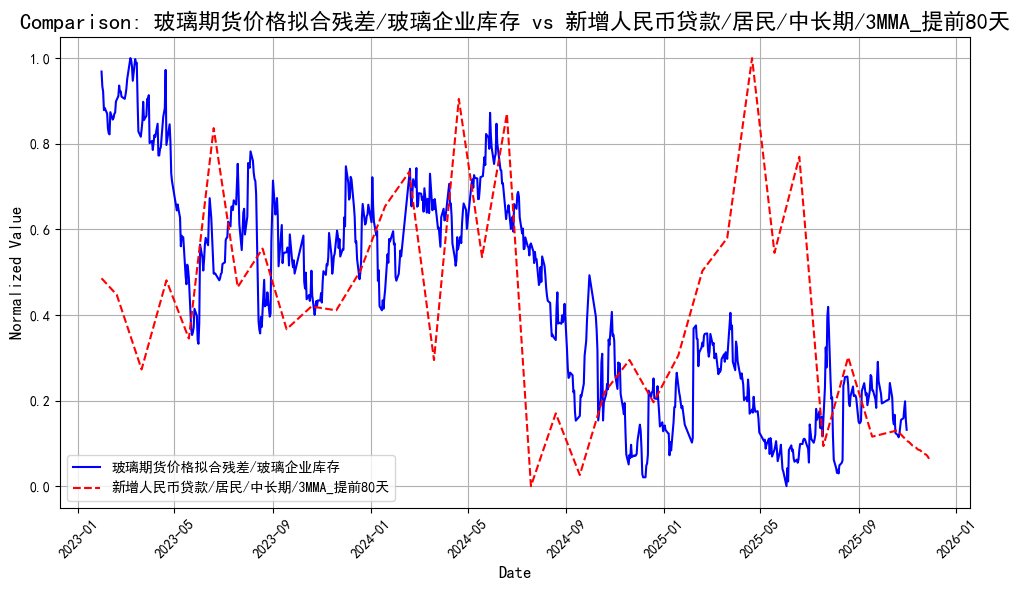

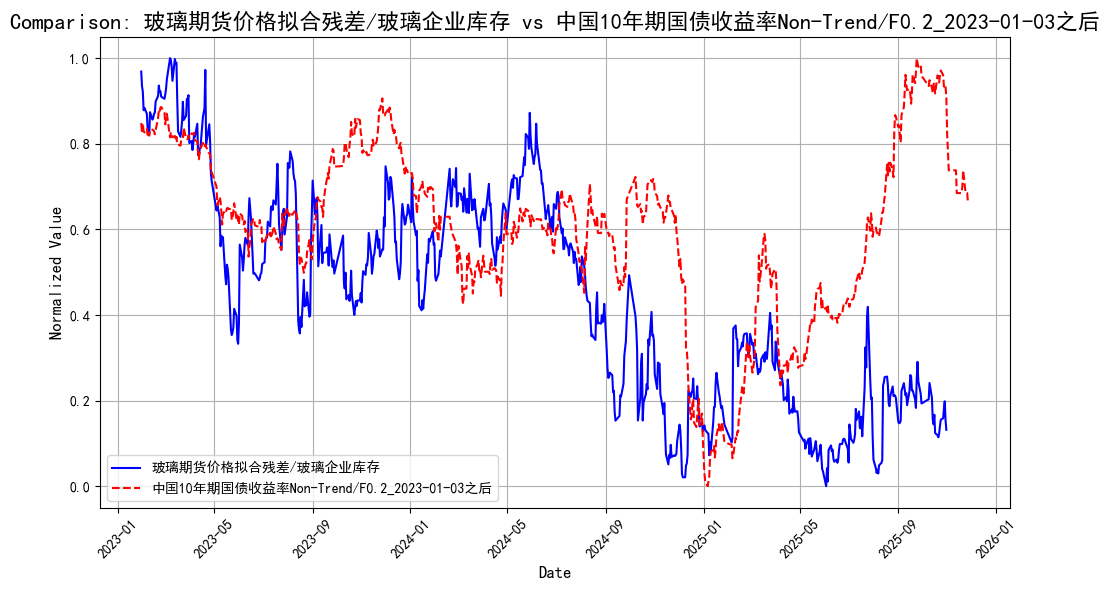

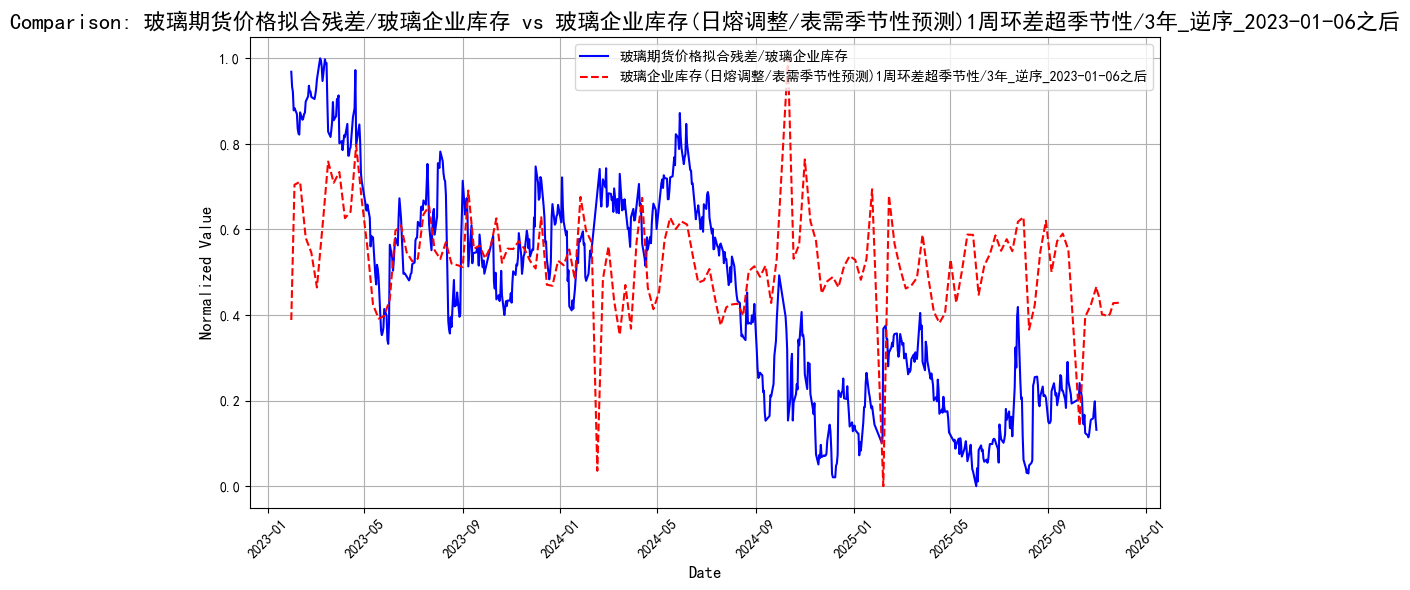

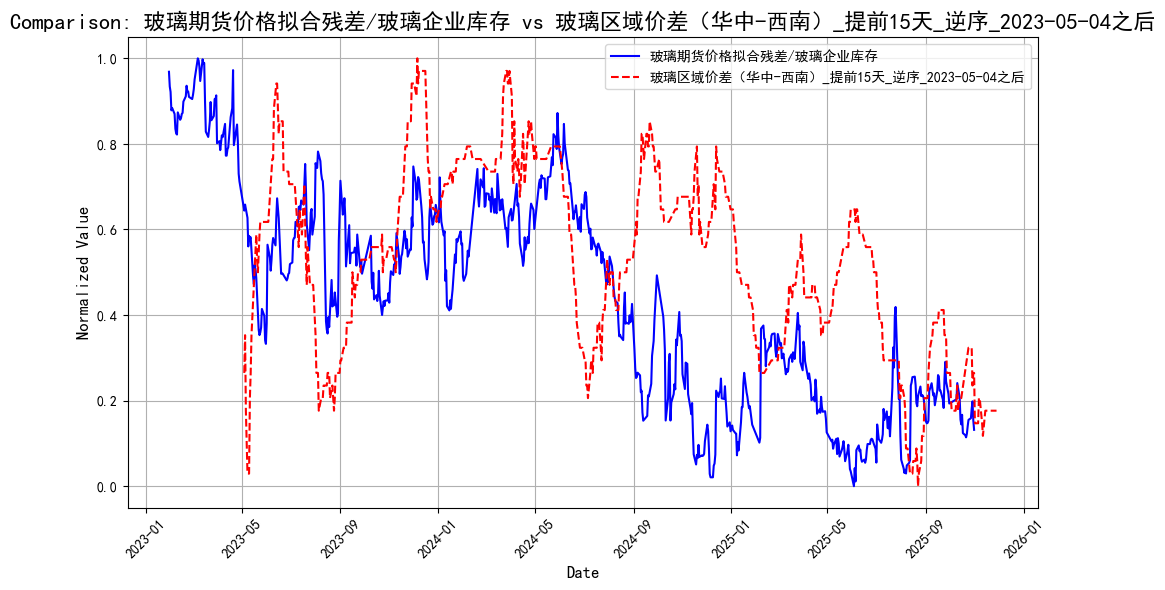

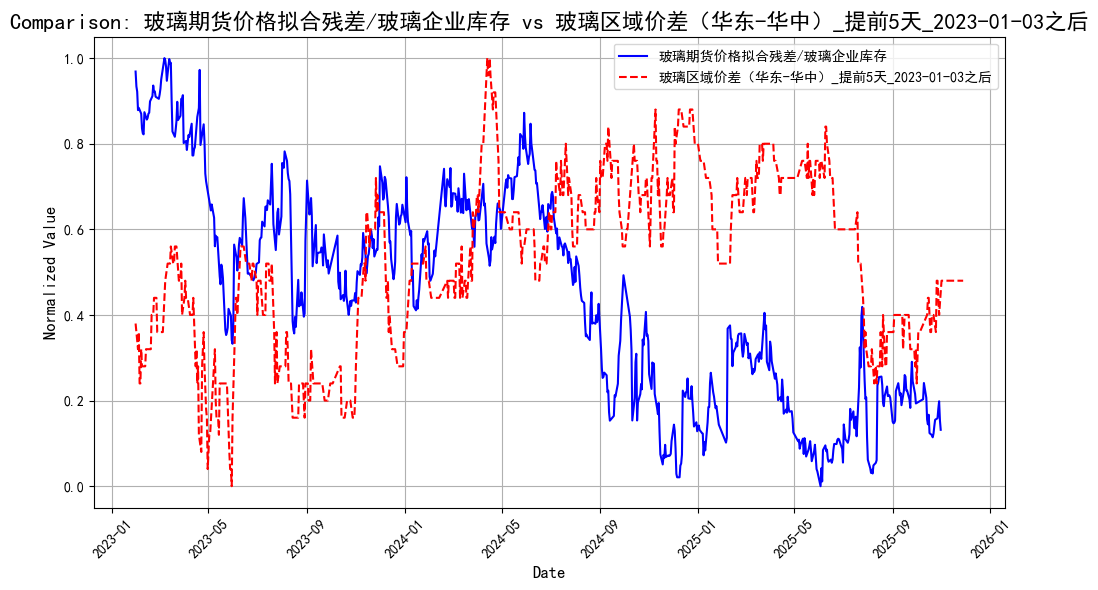

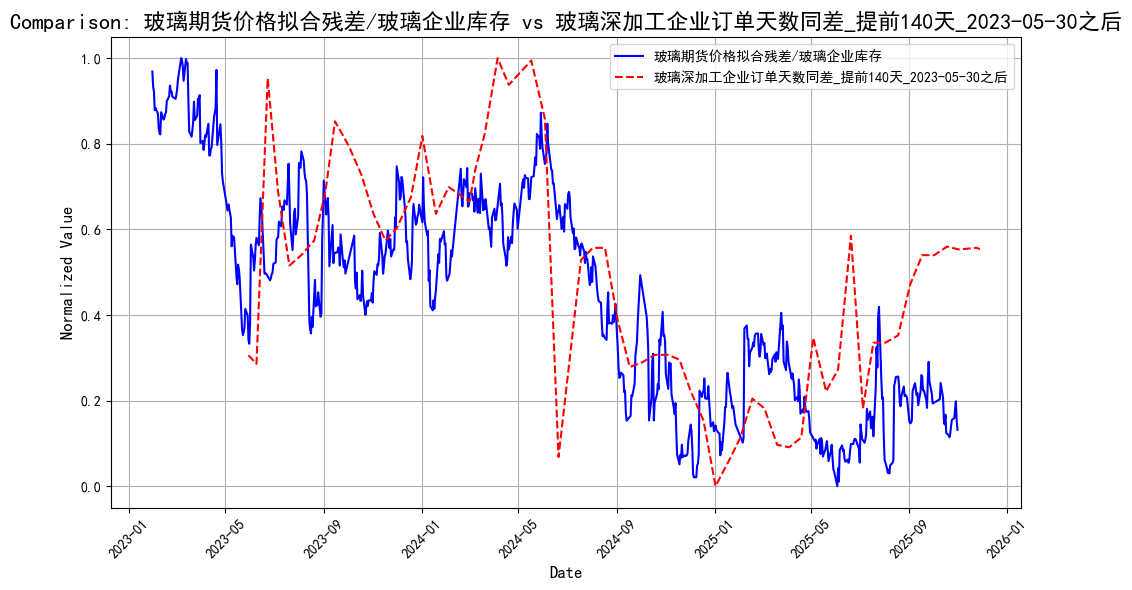

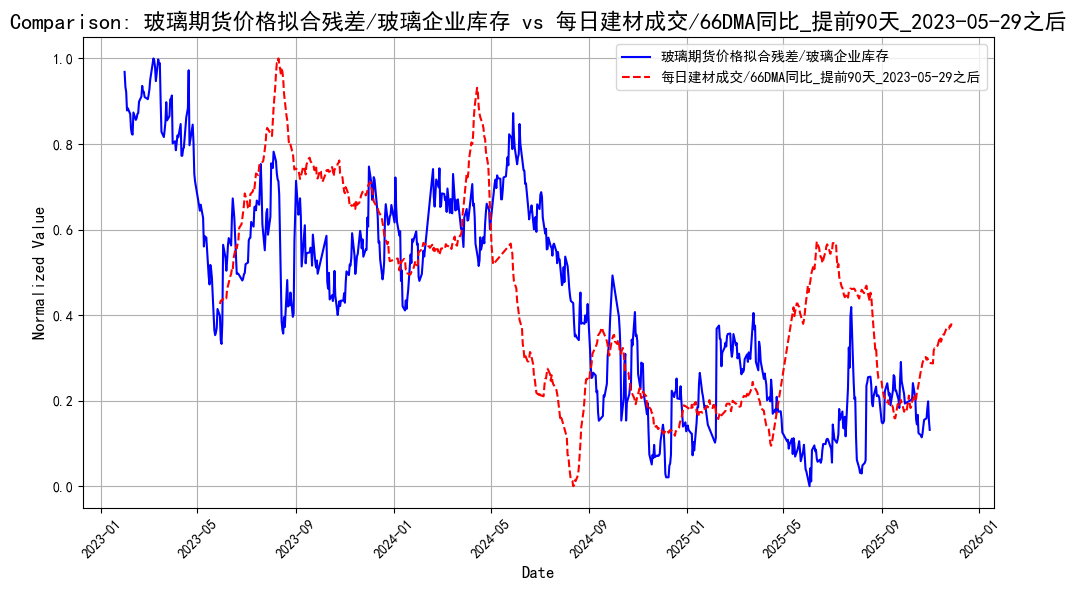

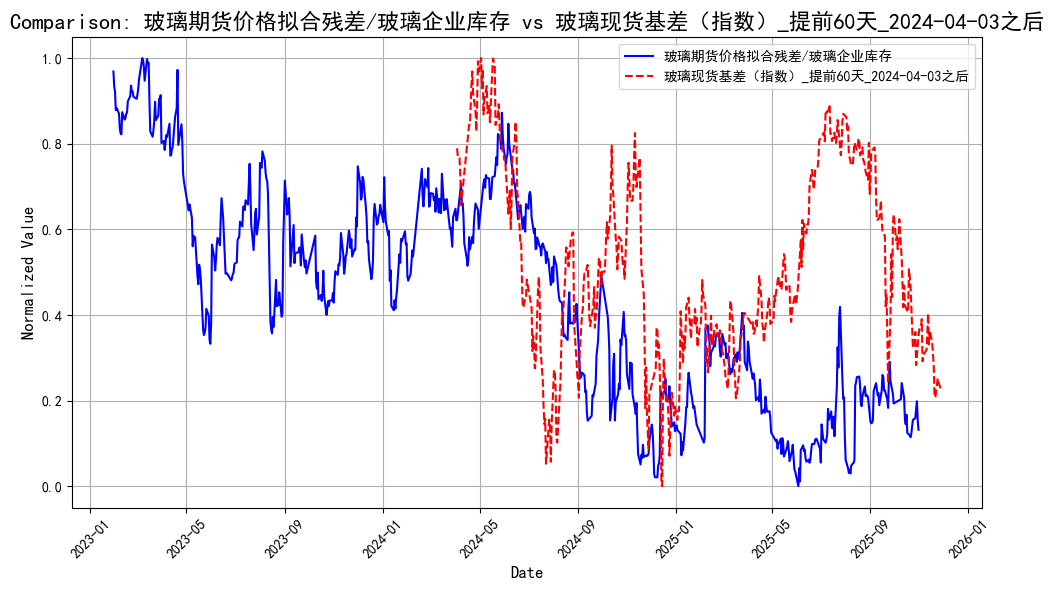

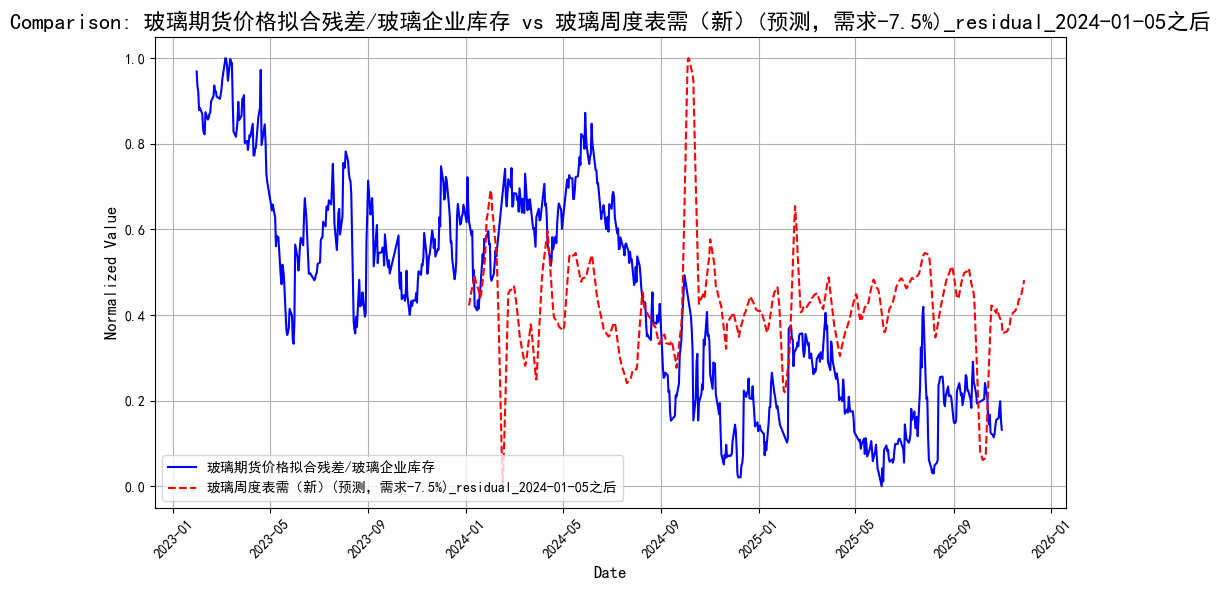

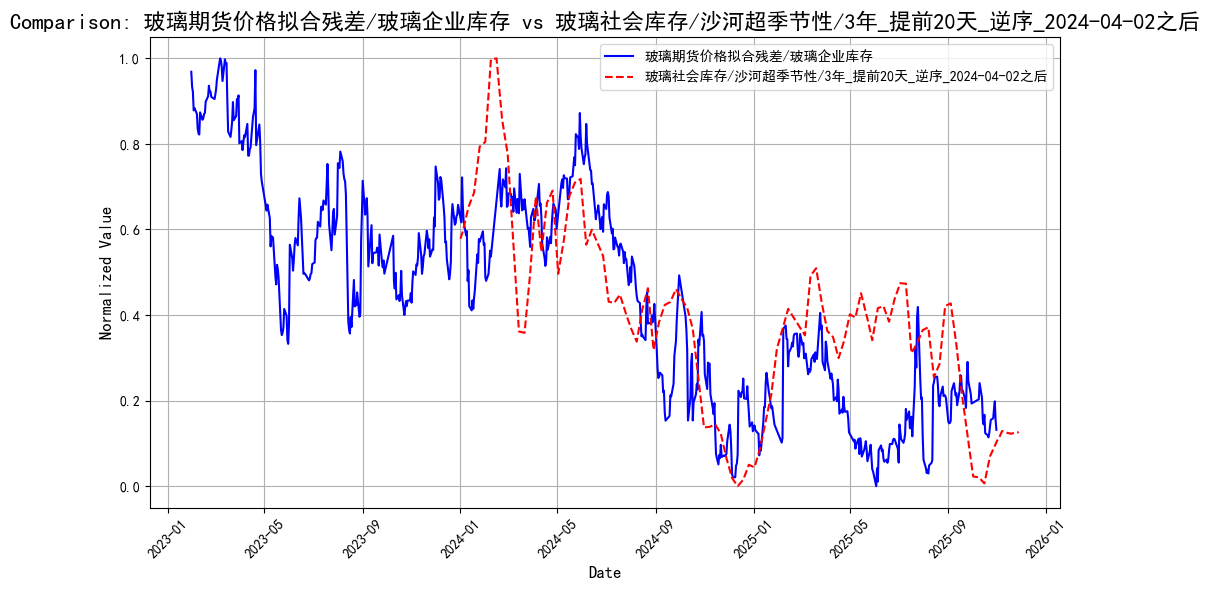

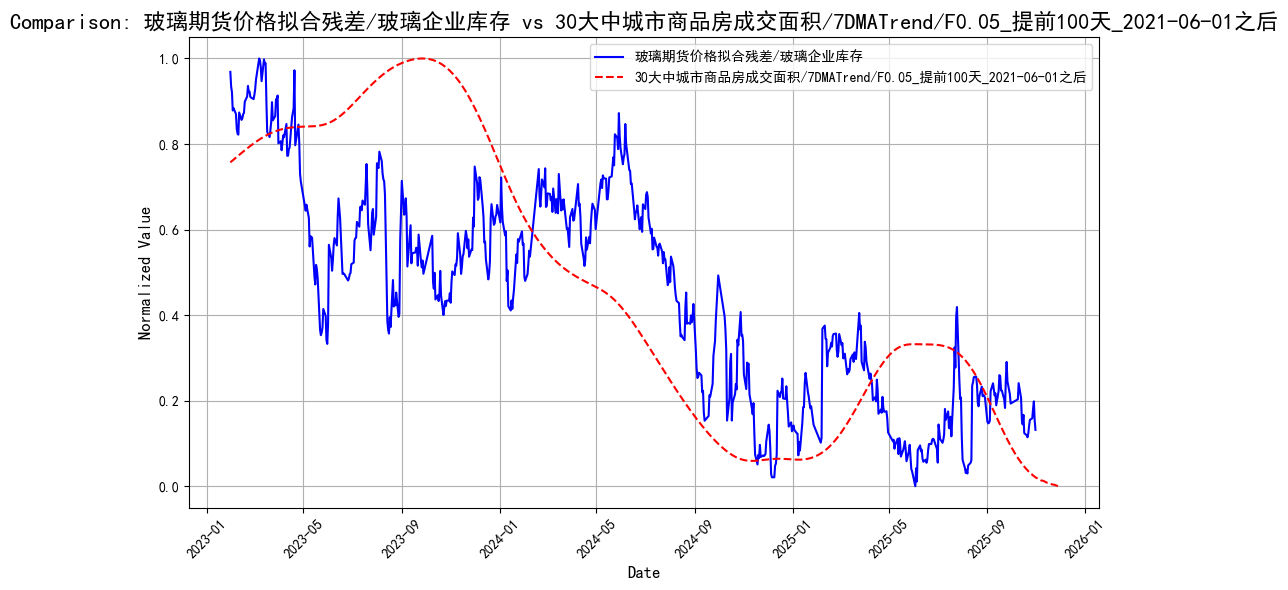

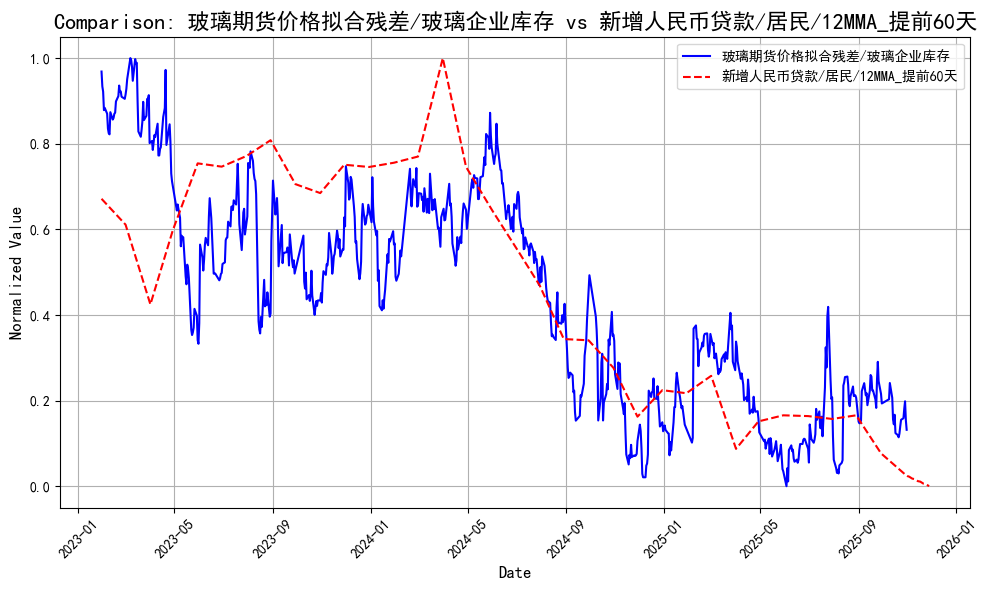

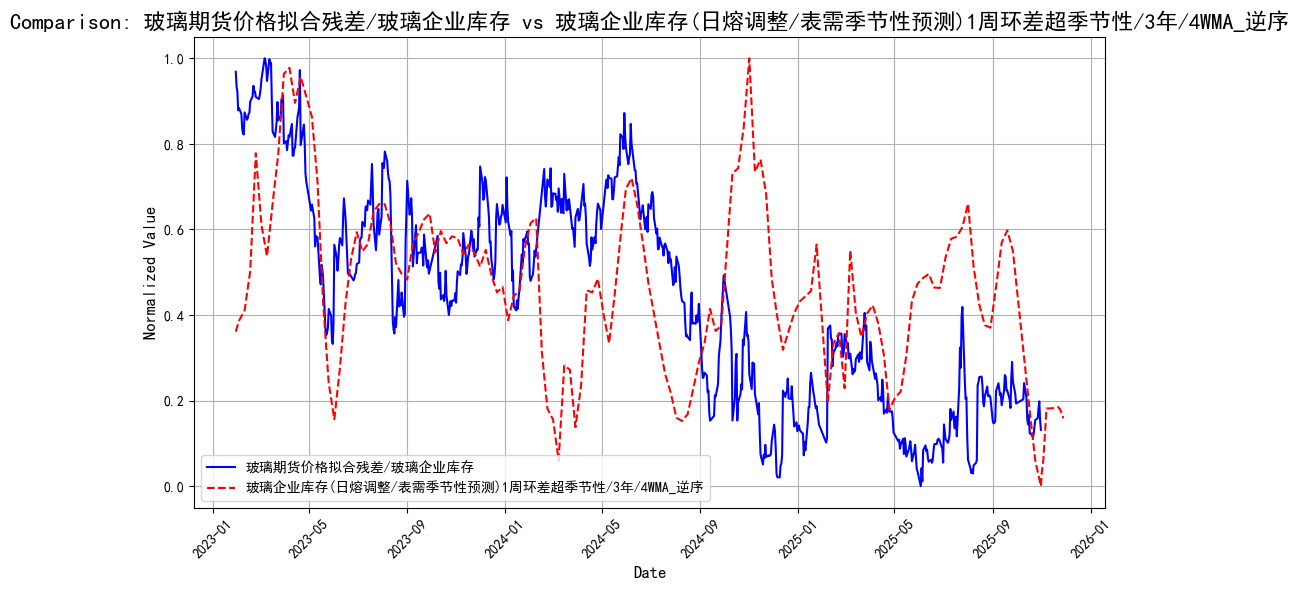

In [68]:
sheet_daily_plot = sheet_daily.set_index('Date')
sheet_daily_plot = sheet_daily_plot['2020':]

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='玻璃期货价格拟合残差/玻璃企业库存', 
    compare_cols=[
        '新增人民币贷款/居民/中长期/3MMA_提前80天',
        '中国10年期国债收益率Non-Trend/F0.2_2023-01-03之后',
        '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年_逆序_2023-01-06之后',
        '玻璃区域价差（华中-西南）_提前15天_逆序_2023-05-04之后',
        '玻璃区域价差（华东-华中）_提前5天_2023-01-03之后',
        '玻璃深加工企业订单天数同差_提前140天_2023-05-30之后',
        '每日建材成交/66DMA同比_提前90天_2023-05-29之后',
        '玻璃现货基差（指数）_提前60天_2024-04-03之后',
        '玻璃周度表需（新）(预测，需求-7.5%)_residual_2024-01-05之后',
        '玻璃社会库存/沙河超季节性/3年_提前20天_逆序_2024-04-02之后',
        '30大中城市商品房成交面积/7DMATrend/F0.05_提前100天_2021-06-01之后',
        '新增人民币贷款/居民/12MMA_提前60天',
        '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA_逆序'
        ]
)

In [69]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
#        '新增人民币贷款/居民/中长期/3MMA_提前80天',
        '中国10年期国债收益率Non-Trend/F0.2_2023-01-03之后',
        '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年_逆序_2023-01-06之后',
        '玻璃区域价差（华中-西南）_提前15天_逆序_2023-05-04之后',
        '玻璃区域价差（华东-华中）_提前5天_2023-01-03之后',
        '玻璃深加工企业订单天数同差_提前140天_2023-05-30之后',
        '每日建材成交/66DMA同比_提前90天_2023-05-29之后',
        '玻璃现货基差（指数）_提前60天_2024-04-03之后',
        '玻璃周度表需（新）(预测，需求-7.5%)_residual_2024-01-05之后',
        '玻璃社会库存/沙河超季节性/3年_提前20天_逆序_2024-04-02之后',
        '30大中城市商品房成交面积/7DMATrend/F0.05_提前100天_2021-06-01之后',
        '新增人民币贷款/居民/12MMA_提前60天',
        '玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA_逆序'
]

predict_column = '玻璃期货价格拟合残差/玻璃企业库存'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 95)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.3,  # 学习率
    'max_depth': 6,  # 树的最大深度
    'min_child_weight': 3,  # 最小子节点权重
    'subsample': 0.4,  # 样本采样比例
    'colsample_bytree': 0.4,  # 特征采样比例
    'gamma': 0.01,  # 最小分裂损失
    'reg_alpha': 0.8,  # L1正则化
    'reg_lambda': 0.4,  # L2正则化
    'eval_metric':'rmse',  # 评估指标
    'seed': 42  # 随机种子
}



num_boost_round = 200
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:184.55650	train-rmse:144.24056
[199]	eval-rmse:105.69852	train-rmse:4.00364
训练集 MSE (DMatrix): 16.1718, 训练集 R² (DMatrix): 0.9996
测试集 MSE (DMatrix): 11172.1765, 测试集 R² (DMatrix): -18.8286


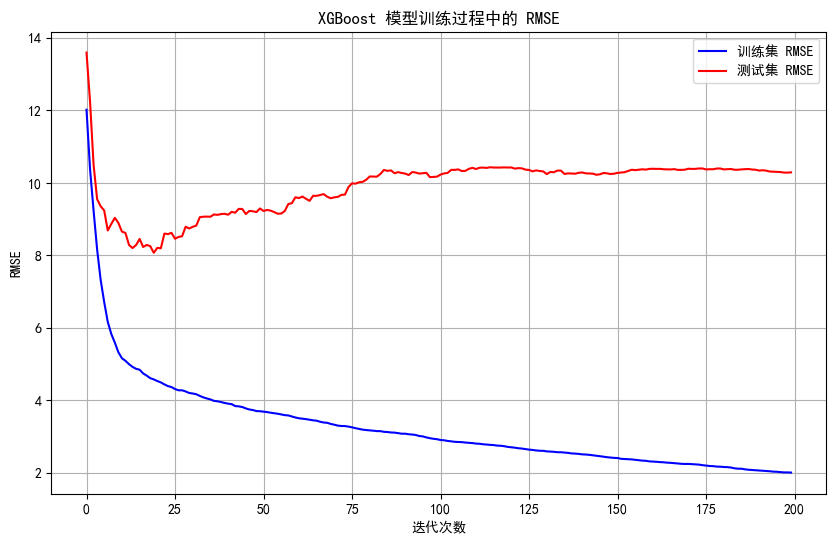

In [70]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:144.62881
[199]	train-rmse:4.08499
全部数据 MSE: 16.9651, 全部数据 R²: 0.9996


Gap between last actual value and first prediction: -12.440282714843761


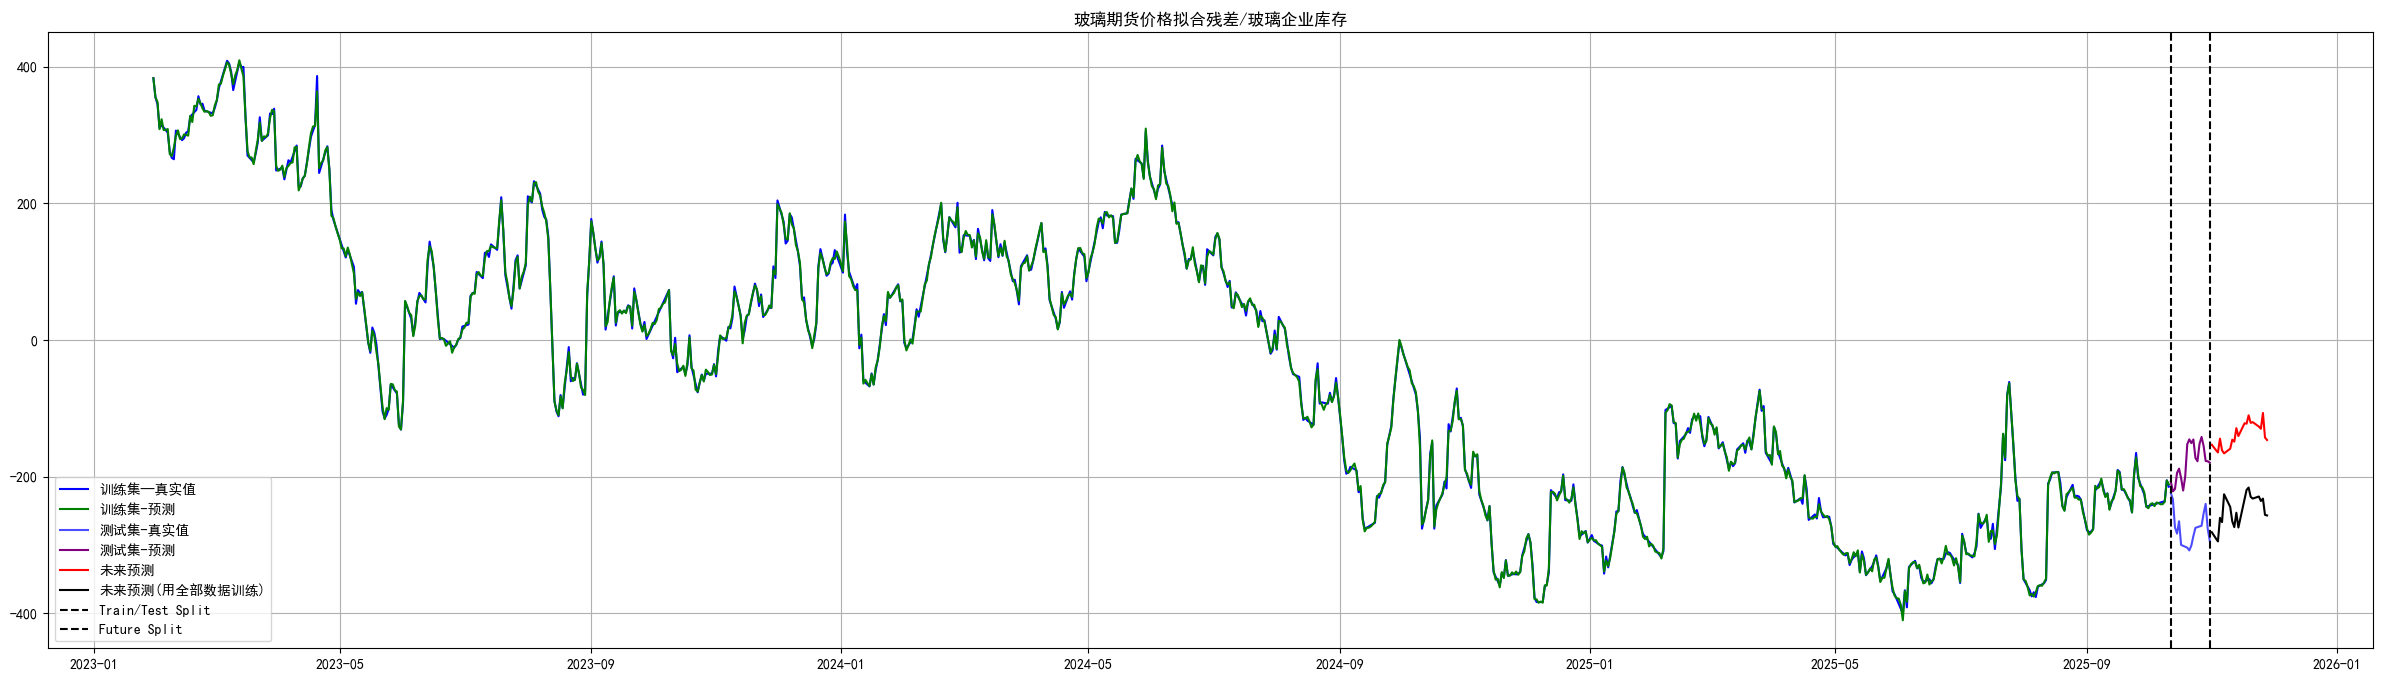

In [72]:



plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('玻璃期货价格拟合残差/玻璃企业库存')
plt.legend()
plt.grid(True)
plt.show()

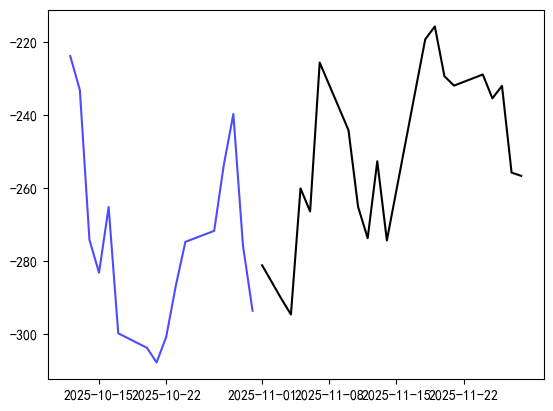

In [73]:
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

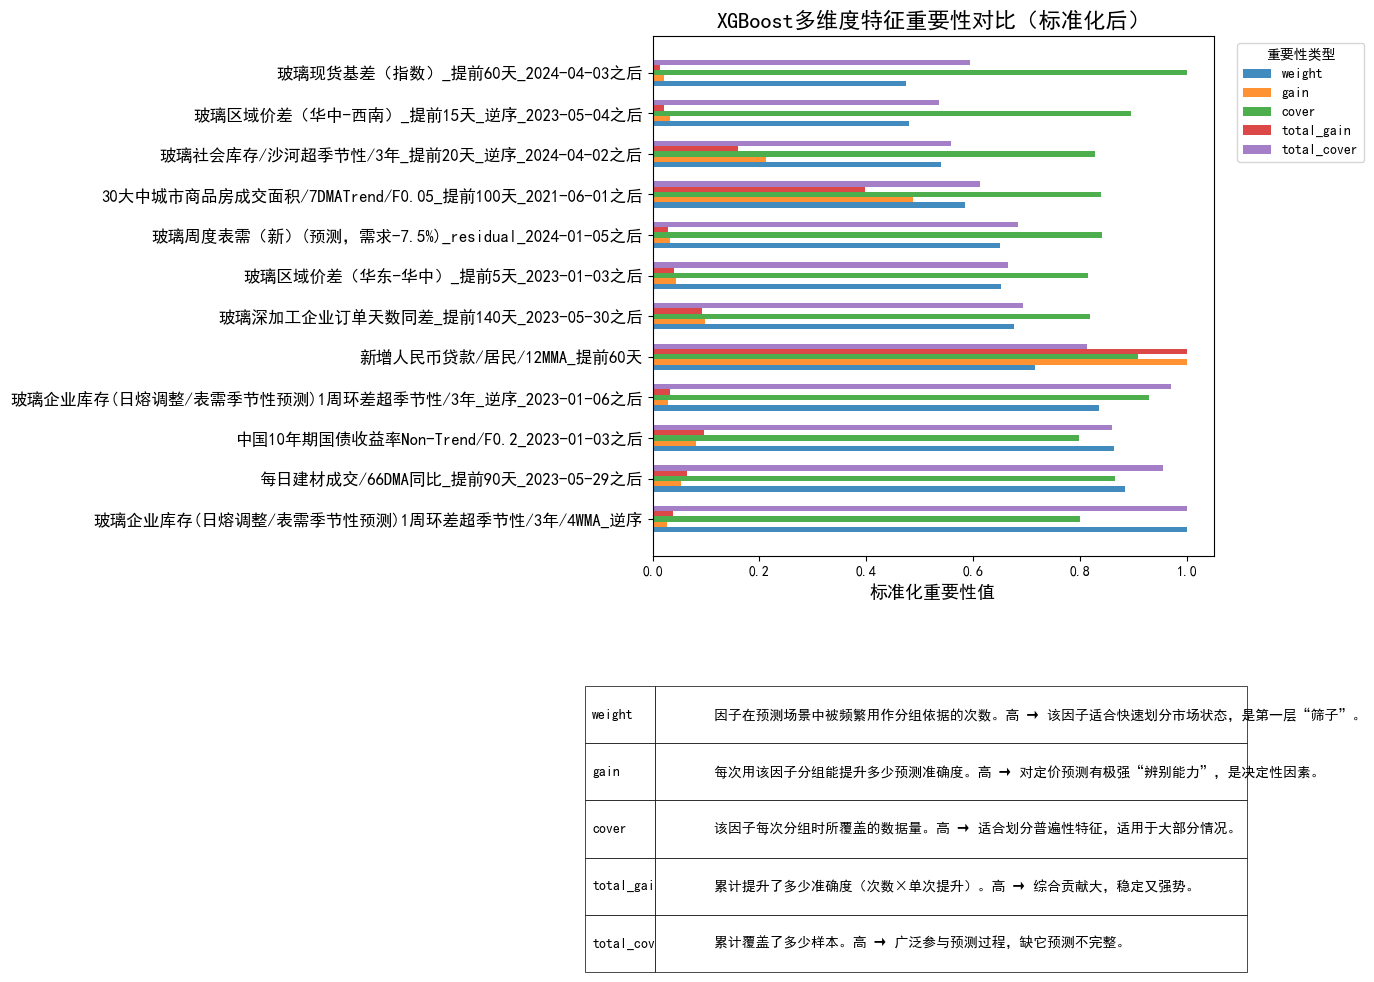

,weight,gain,cover,total_gain,total_cover
玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年/4WMA_逆序,1.000000,0.027820,0.800118,0.038873,1.000000
每日建材成交/66DMA同比_提前90天_2023-05-29之后,0.883683,0.052274,0.865228,0.064546,0.955593
中国10年期国债收益率Non-Trend/F0.2_2023-01-03之后,0.862682,0.080504,0.798020,0.097041,0.860420
玻璃企业库存(日熔调整/表需季节性预测)1周环差超季节性/3年_逆序_2023-01-06之后,0.835218,0.028598,0.929553,0.033375,0.970330
新增人民币贷款/居民/12MMA_提前60天,0.715670,1.000000,0.909196,1.000000,0.813236
玻璃深加工企业订单天数同差_提前140天_2023-05-30之后,0.676898,0.098066,0.818843,0.092754,0.692739
玻璃区域价差（华东-华中）_提前5天_2023-01-03之后,0.652666,0.043479,0.814937,0.039652,0.664754
玻璃周度表需（新）(预测，需求-7.5%)_residual_2024-01-05之后,0.651050,0.031772,0.841452,0.028903,0.684683
30大中城市商品房成交面积/7DMATrend/F0.05_提前100天_2021-06-01之后,0.584814,0.487174,0.838912,0.398097,0.613169
玻璃社会库存/沙河超季节性/3年_提前20天_逆序_2024-04-02之后,0.539580,0.212921,0.828426,0.160532,0.558670


In [74]:
#绘制因子重要
plot_xgb_feature_importance(model_all, X_train)

---

In [75]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/玻璃期货价格拟合残差-玻璃企业库存_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
1026,2025/11/28,NaN,-146.270264
1025,2025/11/27,NaN,-142.648438
1024,2025/11/26,NaN,-106.705513
1023,2025/11/25,NaN,-129.798141
1022,2025/11/24,NaN,-126.667252
...,...,...,...
4,2023/02/03,314.6273,NaN
3,2023/02/02,310.3147,NaN
2,2023/02/01,345.3147,NaN
1,2023/01/31,355.3147,NaN


In [76]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/玻璃期货价格拟合残差-玻璃企业库存_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
34,2025/11/30,NaN,-139.085068
33,2025/10/31,-261.731306,-198.613388
32,2025/09/30,-226.743397,-226.850342
31,2025/08/31,-275.556032,-276.224243
30,2025/07/31,-248.735977,-248.240463


In [77]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "玻璃期货价格拟合残差/玻璃企业库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [78]:
from Lcel import update_excel_data
file_path = "eta/1.玻璃纯碱_数据上传.xlsx"
sheet_name = "详情页"
identifier = "玻璃期货价格拟合残差/玻璃企业库存"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
